In [2]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_data = map( lambda x: x-width/2 , x_raw )
y_data = map( lambda x: x-height/2 , y_raw )
domain = (-width/2,width/2,-height/2,height/2)

width = 1980.000000, height = 1093.000000


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
theta = np.load('theta_opt_stat_mech.npy')

# Modified Hausdorff Distance

In [5]:
def modified_Hausdorff_distance(x_a, y_a, x_b, y_b):
    #computes the modified Hausdorff distance between two point sets.
    return max( mhd_helper(x_a, y_a, x_b, y_b) , mhd_helper(x_b, y_b, x_a, y_a) )

def mhd_helper(x_a, y_a, x_b, y_b):
    out = 0
    for x,y in zip(x_a,y_a):
        out += np.sqrt( np.min( (x_b - x)**2 + (y_b-y)**2 ) )
    out = out / len(x_a)
    return out

## Collocation

In [119]:
def get_vars( dec_vars ):
    n = (len(dec_vars))/2
    x_int = dec_vars[:n]
    y_int = dec_vars[n:2*n]
    return x_int, y_int

def length( dec_vars, x0, y0, xf, yf ):
    #computes the action of a curve
    global theta, width, height
    x_int, y_int = get_vars(dec_vars)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    u = ( x[1:] - x[:n-1] )
    v = ( y[1:] - y[:n-1] )
    return 0.5*np.dot(u,u) + 0.5*np.dot(v,v)
    
def jac_length(dec_vars, x0, y0, xf, yf ):
    #computes the jacobian of the action functional
    x_int, y_int = get_vars(dec_vars)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    u = ( x[1:] - x[:n-1] )
    v = ( y[1:] - y[:n-1] )
    ax = ( -x[2:n] + 2*x[1:n-1] - x[0:n-2]  )
    ay = ( -y[2:n] + 2*y[1:n-1] - y[0:n-2]  )
    dlength_dT = -0.5*(np.dot(u,u)+np.dot(v,v)) 
    return np.hstack( [ax, ay] )

def action( dec_vars , x0, y0, xf, yf ):
    #computes the action of a curve
    global theta, width, height
    x_int, y_int = get_vars( dec_vars)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    from numpy.polynomial.legendre import legval2d
    V_sum = legval2d(2*x[1:n-1]/width, 2*y[1:n-1]/height, theta).sum()
    return length( dec_vars, x0, y0, xf, yf) - V_sum

def jac_action( dec_vars , x0, y0, xf, yf ):
    #this is also the jacobian of the action
    global theta, width, height
    x_int, y_int = get_vars( dec_vars)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    from numpy.polynomial.legendre import legder, legval2d
    theta_x = legder( theta, m=1, axis=0)
    theta_y = legder( theta, m=1, axis=1)
    V_x = 2*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_x)/width
    V_y = 2*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_y)/height
    return np.hstack([-V_x, -V_y]) + jac_length( dec_vars, x0, y0, xf, yf)

def hess_action( dec_vars , x0, y0, xf, yf):
    #the jacobian of the EL constraint [ [A+Vxx, Vxy], [Vxy, A+Vyy] ]
    global theta, width, height
    x_int, y_int = get_vars(dec_vars)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    from scipy import sparse
    diags = np.ones((3,n))
    diags[1,:] = -2*np.ones(n)
    A = sparse.dia_matrix( (diags, [-1,0,1]) , shape = (n-2,n-2))
    from numpy.polynomial.legendre import legder, legval2d
    theta_xx = legder( theta, m=2, axis=0)
    theta_yy = legder( theta, m=2, axis=1)
    theta_xy = legder( legder( theta, axis=0 ) , axis=1 )
    Vxx = 4*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_xx)/(width**2)
    Vxx = sparse.dia_matrix( ( Vxx, 0), shape=(n-2,n-2) )
    Vyy = 4*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_yy)/(height**2)
    Vyy = sparse.dia_matrix( ( Vyy, 0), shape=(n-2,n-2) )
    Vxy = 4*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_xy)/(width*height)
    Vxy = sparse.dia_matrix( ( Vxy, 0), shape=(n-2,n-2) )
    out = -sparse.vstack( [ sparse.hstack( [A+Vxx, Vxy] ) , sparse.hstack([Vxy, A+Vyy]) ] ) 
    return out.toarray()


def get_optimal_curve(x_begin, y_begin, x_end, y_end, n_steps, guess=None):
    # computes the optimal curve which satisfies the dynamics.
    global height, width, action, EL_constraint, gradient_descent
    if guess is None:
        x_guess = np.linspace(x_begin, x_end, n_steps)[1:n_steps-1]
        y_guess = np.linspace(y_begin, y_end, n_steps)[1:n_steps-1]
        guess = np.hstack([x_guess,y_guess])
    from scipy.optimize import minimize
    constraint_list = []
    bounds = [(-width/2,width/2)]*(n_steps-2) + [(-height/2,height/2)]*(n_steps-2)
    #constraint_list.append( {'type':'eq', 'fun':EL_constraint, 'args':(x_begin, y_begin, x_end, y_end),'jac':jac_EL})
    res = minimize( action, guess, jac = jac_action, hess= hess_action, bounds = bounds, method='Newton-CG',
                   args=(x_begin,y_begin,x_end,y_end), options = {'maxiter':1000})
    print res.message
    x,y = get_vars( res.x)
    x,y = get_vars( xy_int )
    x = np.hstack([x_begin, x, x_end])
    y = np.hstack([y_begin, y, y_end])
    return x,y

In [120]:
x0 = -1.0
xf = 1.0
y0 = 1.2
yf = 2.1

x = np.linspace(x0,xf,10)
y = np.linspace(x0,xf,10)
dec_vars = np.hstack( [ x, y] )
h = 1e-6
pert = np.zeros(len(dec_vars))
pert[4] = 1e-5
print len(pert)
print "perturbation size = %.4g" % np.abs(pert).max()

print "TESTING LENGTH"
fd = ( length(dec_vars+pert, x0, y0, xf, yf) - length(dec_vars, x0, y0, xf, yf) )
computed = np.dot( jac_length(dec_vars, x0, y0, xf, yf) , pert ) 
print "finite difference = %g" % fd
print "computed          = %g" % computed

print "TESTING ACTION"
fd = ( action( dec_vars+pert, x0, y0, xf, yf) - action(dec_vars, x0, y0, xf, yf) )
computed = np.dot( jac_action(dec_vars, x0, y0, xf, yf), pert)
print "finite difference = %g" % fd
print "computed          = %g" % computed

print "TESTING HESSIAN"
fd = jac_action(dec_vars+pert,x0,y0,xf,yf)- jac_action(dec_vars,x0,y0,xf,yf)
computed = hess_action( dec_vars, x0, y0, xf, yf).dot( pert)
print fd
print computed

20
perturbation size = 1e-05
TESTING LENGTH
finite difference = 1e-10
computed          = -1.11022e-21
TESTING ACTION
finite difference = 2.04506e-06
computed          = 2.04496e-06
TESTING HESSIAN
[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.00000000e-05
   1.99870801e-05  -1.00000000e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   3.59134830e-09   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.00000000e-05
   1.99870801e-05  -1.00000000e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   3.59134615e-09   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


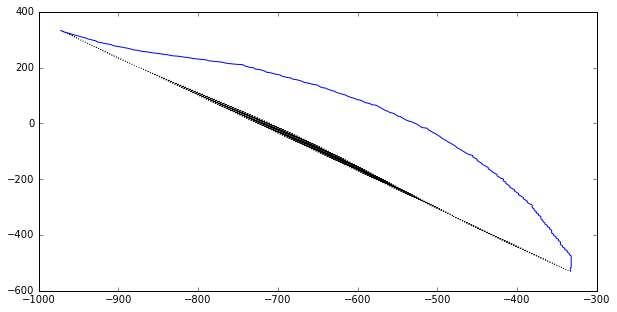

In [128]:
curve_ind = 2
fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(x_data[curve_ind], y_data[curve_ind], 'b-')

n_steps = len( x_data[curve_ind])
x_begin = x_data[curve_ind][0]
y_begin = y_data[curve_ind][0]
x_end = x_data[curve_ind][-1]
y_end = y_data[curve_ind][-1]

x_int = np.linspace(x_begin, x_end, n_steps)[1:n_steps-1]
y_int = np.linspace(y_begin, y_end, n_steps)[1:n_steps-1]
#ax.plot( x_int, y_int , 'r-')

xy_int = np.hstack( [x_int, y_int])
dx_int,dy_int = get_vars( jac_action( xy_int, x_begin, y_begin, x_end, y_end ) )
gamma = 10
for k in range( 0,len(x_int)):
    ax.arrow(x_int[k], y_int[k], gamma*dx_int[k], gamma*dy_int[k], head_length=1)

In [125]:
x,y = get_optimal_curve(x_begin, y_begin, x_end, y_end, n_steps)

Optimization terminated successfully.


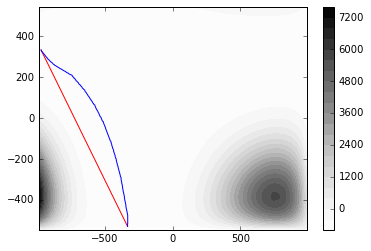

In [126]:
plt.plot(x,y, 'r-')
plt.plot(x_data[curve_ind], y_data[curve_ind])

x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50), np.linspace(-height/2,height/2,50))
from numpy.polynomial.legendre import legval2d
plt.contourf( x_grid, y_grid, legval2d(2*x_grid/width,2*y_grid/height,theta) , 20, cmap='Greys')
plt.colorbar()

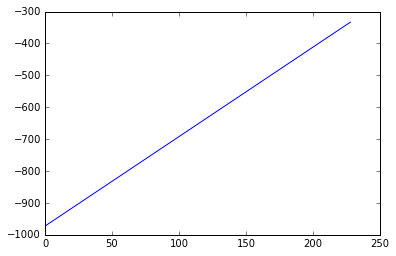

In [127]:
print plt.plot( x)

In [144]:
for i in range(len(x_data)):
    fname = 'coup_curves/curve_%d.csv' % i
    array_to_save = np.vstack( [x_data[i], y_data[i]] )
    np.savetxt(fname, array_to_save, delimiter=',')
    

In [145]:
BC = np.zeros( (len(x_data),5) )
for i in range( len(x_data)):
    BC[i,0] = x_data[i][0]
    BC[i,1] = y_data[i][0]
    BC[i,2] = x_data[i][-1]
    BC[i,3] = y_data[i][-1]
    BC[i,4] = len(x_data[i])

np.savetxt('boundary_conditions', BC, delimiter=',')

In [146]:
print BC


[[-957.5  398.5  952.5  378.   433. ]
 [-949.5  373.5 -956.   292.5  601. ]
 [-972.5  333.5 -333.  -530.5  229. ]
 [-950.5  412.5  966.   410.   542. ]
 [ 936.   364.5 -964.   288.   308. ]
 [-916.5  331.5  967.5  371.   328. ]
 [-172.  -492.5  967.5  211.   320. ]
 [ 875.5  428.  -128.   218.5  532. ]
 [-935.   290.5 -275.5 -531.5  366. ]
 [-947.5  478.   951.   250.5  412. ]
 [-959.   411.   961.   429.5  355. ]
 [ 947.   497.5 -960.   298.5  449. ]
 [-940.5  290.5  943.   154.5  299. ]
 [-594.  -511.  -975.   258.5  175. ]
 [-340.  -519.  -937.   252.5  204. ]
 [-233.  -512.   933.   340.5  191. ]
 [ 945.5 -512.   915.5 -512.    39. ]
 [ 947.   195.  -176.5 -520.   335. ]
 [ 929.   474.5  693.   518.   158. ]
 [ 398.5  393.   958.   343.   120. ]
 [-927.   244.5 -259.  -519.   220. ]
 [-950.5  339.  -333.  -506.5  213. ]
 [-952.   402.  -272.5 -522.5  316. ]
 [ 944.5  131.  -363.5 -515.5  830. ]
 [ 958.   281.  -950.5  305.   366. ]
 [-364.5 -513.  -938.5  200.5  215. ]
 [-949.5  36

In [147]:
print width/2


990
